In [30]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [31]:
def read_data(path,H,W):
    '''
    return:  (W*H, # pics) array , (# pics) array
    '''
    pics=os.listdir(path)
    images=np.zeros((W*H,len(pics)))
    label=np.zeros(len(pics)).astype('uint8')
    
    for pic,i in zip(pics,np.arange(len(pics))):
        label[i]=int(pic.split('.')[0][7:9])-1
        image=np.asarray(Image.open(os.path.join(path,pic)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i]=image

    return images,label

def accuracy(x_test,y_test,z_train,y_train,U,x_mean=None,k=3):
    '''
    using k-nn to predict x_test's label
    x_test:  (H*W, # pics) array
    y_test:   (# pics) array
    z_train:  (low-dim, #pics) array
    y_train:  (# pics) array
    U: Transform matrix
    x_mean:  using when estimate eigenface
    k: k of k-nn

    '''
    if x_mean is None:
        x_mean=np.zeros((X_test.shape[0],1))

    # reduce dim (projection)
    z_test=U.T@(x_test-x_mean)

    # k-nn
    predicted_y=np.zeros(z_test.shape[1])
    for i in range(z_test.shape[1]):
        distance=np.zeros(z_train.shape[1])
        for j in range(z_train.shape[1]):
            distance[j]=np.sum(np.square(z_test[:,i]-z_train[:,j]))
        sort_index=np.argsort(distance)
        nearest_neighbors=y_train[sort_index[:k]]
        unique, counts = np.unique(nearest_neighbors, return_counts=True)
        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        predicted_y[i]=nearest_neighbors[0]

    acc=np.count_nonzero((y_test-predicted_y)==0)/len(y_test)
    return acc

In [32]:
# plot all fiures
def plot_eigenface(X,number,H,W):
    # plot the eigenface
    n=int(number**0.5)
    matplotlib.use("Qt5Agg")
    for i in range(number):
        plt.subplot(n,n,i+1)
        plt.imshow(X[:,i].reshape(H,W),cmap='gray')
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
  
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.5, 
                    top=1.5, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.get_current_fig_manager().window.showMaximized()
    plt.show()
    
def show_reconstruction(X,X_recover,num,H,W):
    rand_init=np.random.choice(X.shape[1],num)
    for i in range(num):
        plt.subplot(2,num,i+1)
        plt.imshow(X[:,rand_init[i]].reshape(H,W),cmap='gray')
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.subplot(2,num,i+1+num)
        plt.imshow(X_recover[:,rand_init[i]].reshape(H,W),cmap='gray')
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    
    plt.subplots_adjust(left=0.3,
                    bottom=0.1, 
                    right=3.0, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.get_current_fig_manager().window.showMaximized()
    plt.show()

# PCA and LDA

In [33]:
# PCA function
def pca(x,num_dim=None):
    x_mean = np.mean(x, axis=1).reshape(-1, 1)
    x_center = x - x_mean

    # PCA
    eigenvalues, eigenvectors = np.linalg.eig(x_center.T @ x_center)
    sort_index = np.argsort(-eigenvalues)
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], np.arange(len(eigenvalues))):
            if eigenvalue <= 0:
                sort_index = sort_index[:i]
                break
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=eigenvalues[sort_index]
    # from X.T@X eigenvector --> X@X.T eigenvector
    eigenvectors=x_center@eigenvectors[:, sort_index]
    eigenvectors_norm=np.linalg.norm(eigenvectors,axis=0)
    eigenvectors= eigenvectors/ eigenvectors_norm

    return eigenvalues,eigenvectors,x_mean

In [34]:
# Kernel PCA 

#from scipy.spatial.distance import pdist, squareform

def kernel_pca(x, num_dim=50, kernel = 'polynomial', gamma = 2, C=5, alpha=2, d_poly=2):
    x_mean = np.mean(x, axis=1).reshape(-1, 1)
    x_center = x - x_mean
    
    if kernel == 'polynomial':
        """
        k(x, y) = (alpha * <x, y> + c)^d
        Hiperparámetros: alpha, c, d_poly
        """
        K = (alpha * (x_center.T@x_center) + C)**d_poly
        
        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
        
    elif kernel == 'linear':
        """
        k(x, y) = <x, y> + c
        Hiperparámetros: c
        """
        # Computing the MxM kernel matrix.
        K = x_center.T@x_center + C

        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)   
    
    elif kernel == 'sigmoid':
        """
        k(x, y) = tanh( alpha * <x, y> + c)
        Hiperparámetros: alpha, c
        """
        K = np.tanh(alpha * (x_center.T@x_center) + C)

        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    

    # PCA
    eigenvalues, eigenvectors = np.linalg.eig(K)
    sort_index = np.argsort(-eigenvalues)
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], np.arange(len(eigenvalues))):
            if eigenvalue <= 0:
                sort_index = sort_index[:i]
                break
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=eigenvalues[sort_index]
    # from X.T@X eigenvector --> X@X.T eigenvector
    eigenvectors=x_center@eigenvectors[:, sort_index]
    eigenvectors_norm=np.linalg.norm(eigenvectors,axis=0)
    eigenvectors= eigenvectors/ eigenvectors_norm

    return eigenvectors

Reference:
    
    https://sebastianraschka.com/Articles/2014_kernel_pca.html
    
    https://zhuanlan.zhihu.com/p/92359921
    
    https://github.com/JAVI897/Kernel-PCA/blob/master/kernels.py

In [35]:
# LDA function

def lda(x,y,num_dim=None):
    N=x.shape[0]
    x_mean = np.mean(x, axis=1).reshape(-1, 1)

    C_mean = np.zeros((N, 15))  # 15 classes's means
    for i in range(x.shape[1]):
        C_mean[:, y[i]] += x[:, y[i]]
    C_mean = C_mean / 9

    # within-class scatter Sw
    S_within = np.zeros((N, N))
    for i in range(x.shape[1]):
        d = x[:, y[i]].reshape(-1,1) - C_mean[:, y[i]].reshape(-1,1)
        S_within += d @ d.T
    print(N)
    print(x.shape[1])

    # between-class scatter Sb
    S_between = np.zeros((N, N))
    for i in range(15):
        d = C_mean[:, i].reshape(-1,1) - x_mean
        S_between += 9 * d @ d.T

    eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_within)@S_between)
    sort_index=np.argsort(-eigenvalues)
    if num_dim is None:
        sort_index=sort_index[:-1]  # reduce 1 dim
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')

    return eigenvalues,eigenvectors

In [36]:
# Kernel LDA function

def kernel_lda(x,y,num_dim=None,kernel ='linear',gamma = 2, C=5, alpha=2, d_poly=3):    
    if kernel == 'polynomial':
        """
        k(x, y) = (alpha * <x, y> + c)^d
        Hiperparámetros: alpha, c, d_poly
        """
        K = (alpha * (x.T@x) + C)**d_poly
        
        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
        
    elif kernel == 'linear':
        """
        k(x, y) = <x, y> + c
        Hiperparámetros: c
        """
        # Computing the MxM kernel matrix.
        K = x.T@x + C

        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)   
    
    elif kernel == 'sigmoid':
        """
        k(x, y) = tanh( alpha * <x, y> + c)
        Hiperparámetros: alpha, c
        """
        K = np.tanh(alpha * (x.T@x) + C)

        # Centering the symmetric NxN kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    
    
    N=K.shape[0]
    print(N)
    print(K.shape[1])
    K_mean = np.mean(K, axis=1).reshape(-1, 1)

    C_mean = np.zeros((N, 15))  # 15 classes's means
    for i in range(K.shape[1]):
        C_mean[:, y[i]] += K[:, y[i]]
    C_mean = C_mean / 9    


    # within-class scatter Sw
    S_within = np.zeros((N, N))
    for i in range(K.shape[1]):
        d = K[:, y[i]].reshape(-1,1) - C_mean[:, y[i]].reshape(-1,1)
        S_within += d @ d.T

    # between-class scatter Sb
    S_between = np.zeros((N, N))
    for i in range(15):
        d = C_mean[:, i].reshape(-1,1) - K_mean
        S_between += 9 * d @ d.T

    eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_within)@S_between)
    sort_index=np.argsort(-eigenvalues)
    if num_dim is None:
        sort_index=sort_index[:-1]  # reduce 1 dim
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')

    return eigenvalues,eigenvectors

# Eigenfaces

U shape: (45045, 134)


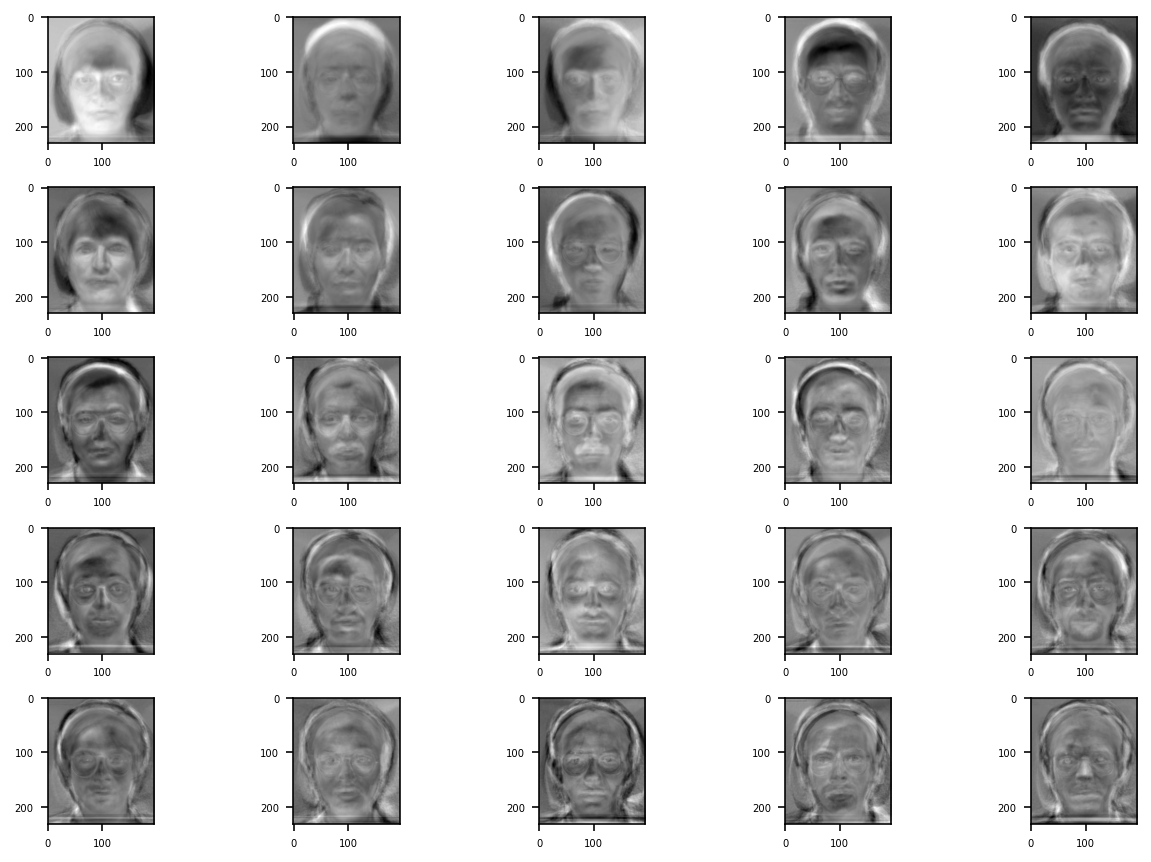

In [16]:
# PCA

# The size of the picture is 231*195
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

eigenvalues,eigenvectors,X_mean=pca(X)

# Calculate transform matrix
U=eigenvectors.copy()
print('U shape: {}'.format(U.shape))

# Show the top 25 eigenface
plot_eigenface(U,25,H,W)

acc: 83.33%


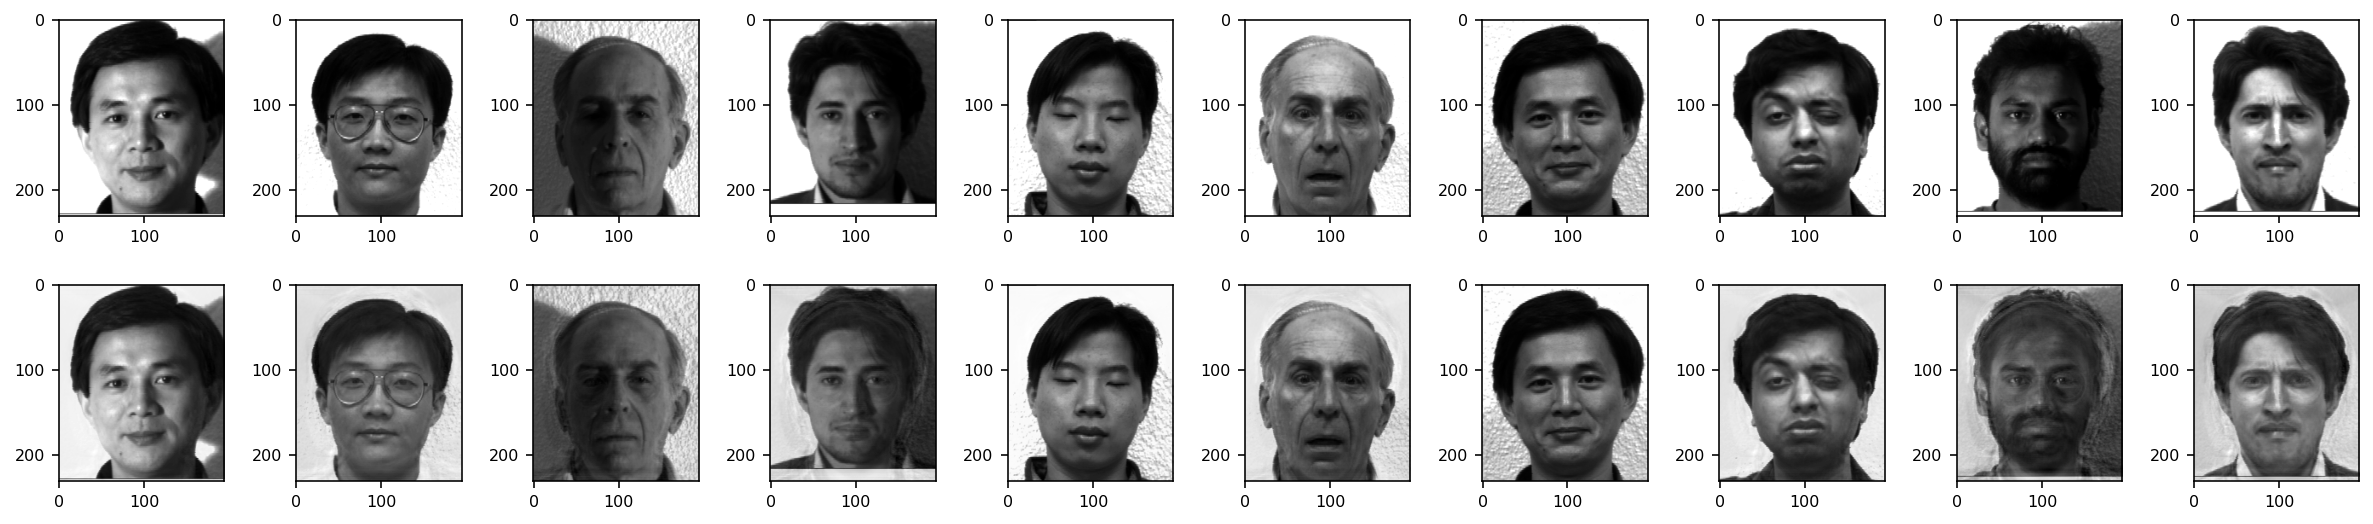

In [17]:
# reduce the dimension (projection)
Z=U.T@(X-X_mean)

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath=os.path.join('Yale_Face_Database','Testing')
X_test,y_test=read_data(filepath,H,W)
acc = accuracy(X_test,y_test,Z,y,U,X_mean,3)
print('acc: {:.2f}%'.format(acc*100))

# sigmoid

U shape: (45045, 50)


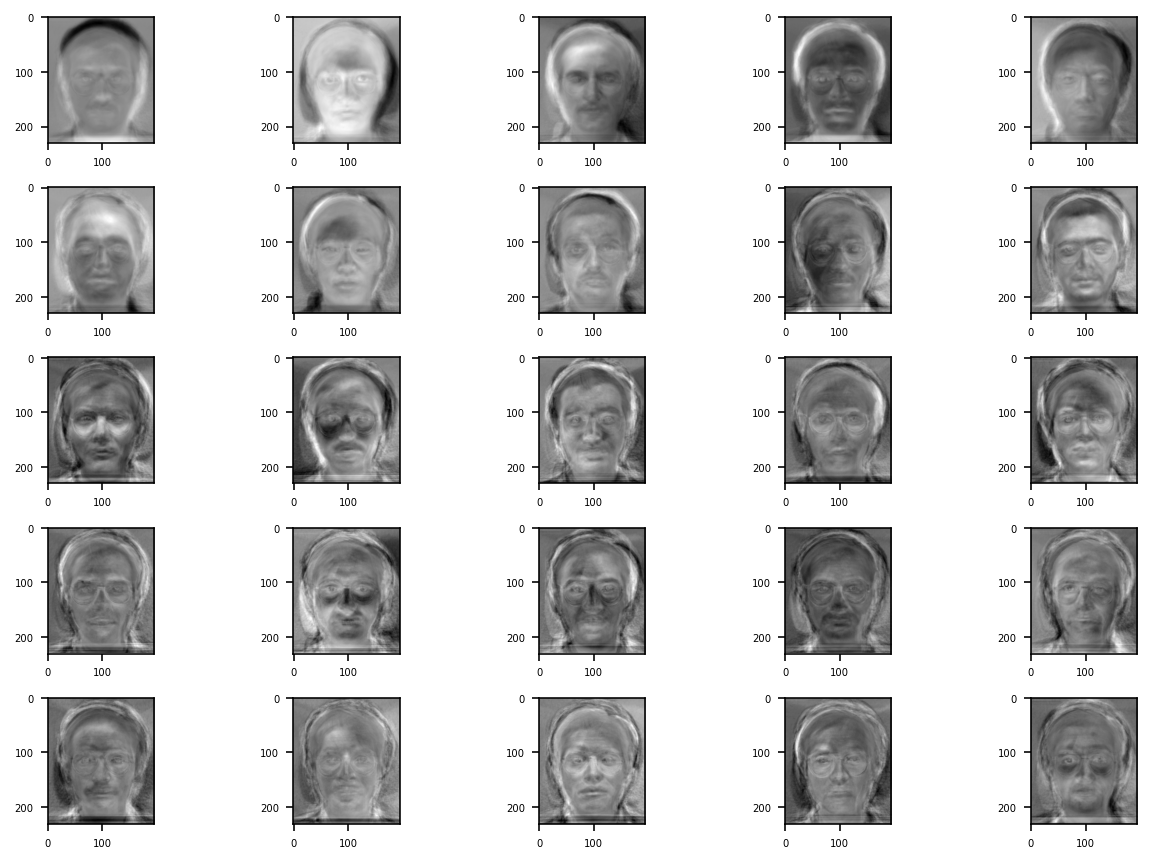

In [18]:
# Try Kernal
# The size of the picture is 231*195
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

eigenvectors=kernel_pca(X,num_dim=50, kernel = 'sigmoid', alpha = 2)


# Calculate transform matrix
U=eigenvectors.copy()
print('U shape: {}'.format(U.shape))

# Show the top 25 eigenface
plot_eigenface(U,25,H,W)

acc: 86.67%


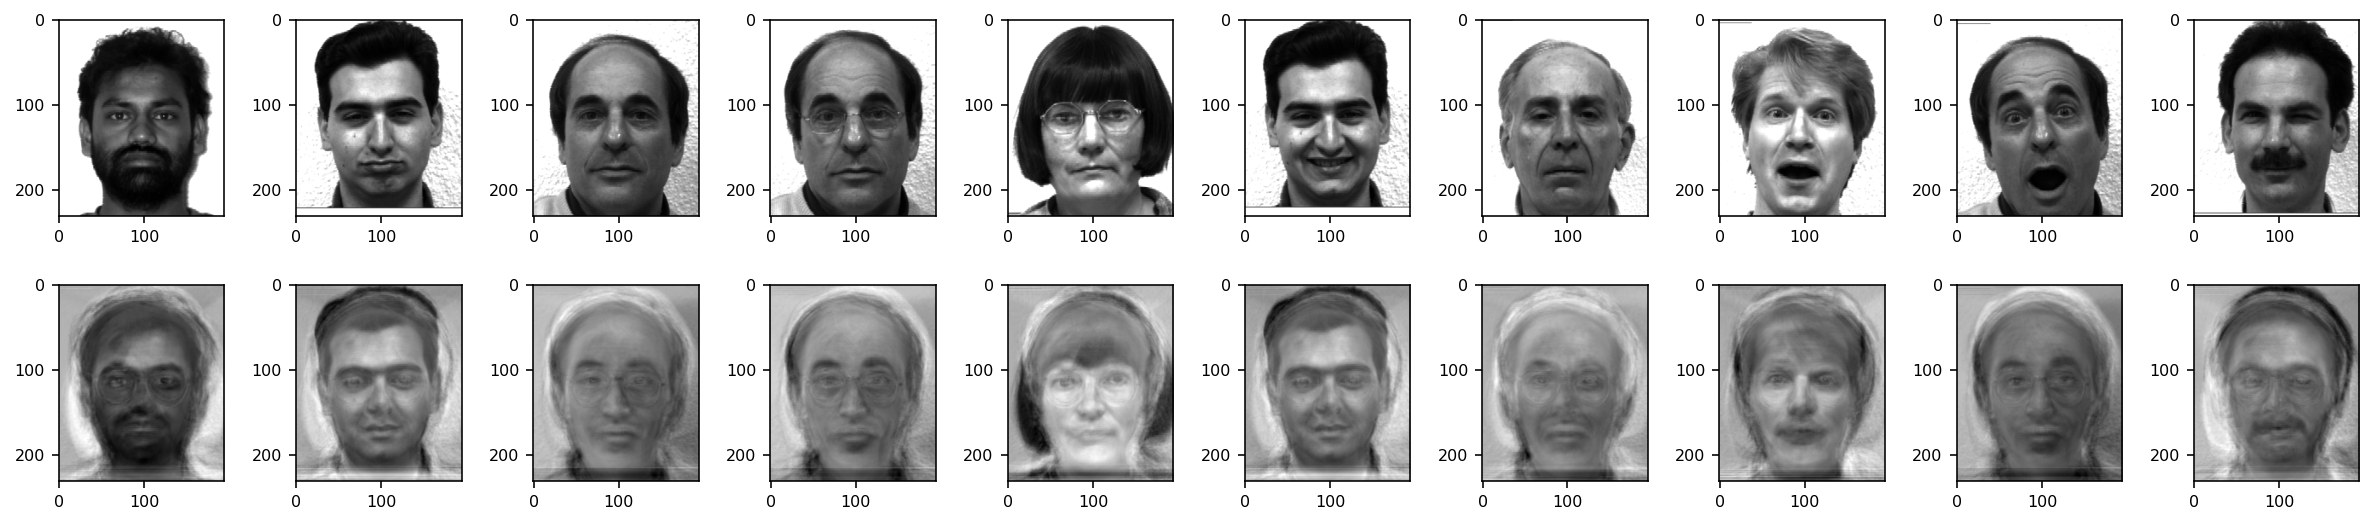

In [19]:
# reduce the dimension (projection)
Z=U.T@(X-X_mean)

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath=os.path.join('Yale_Face_Database','Testing')
X_test,y_test=read_data(filepath,H,W)
acc = accuracy(X_test,y_test,Z,y,U,X_mean,3)
print('acc: {:.2f}%'.format(acc*100))

# polynomial

U shape: (45045, 50)


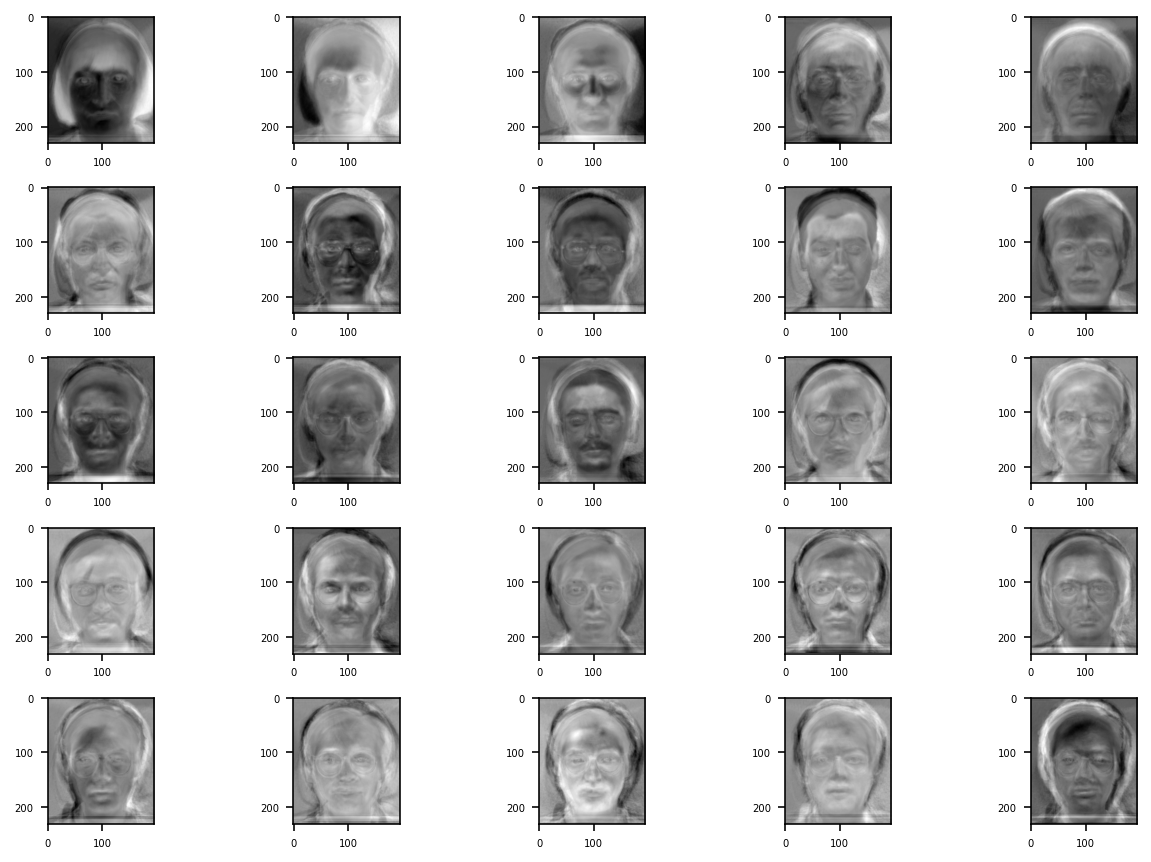

In [20]:
# Try Kernal
# The size of the picture is 231*195
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

eigenvectors=kernel_pca(X,num_dim=50, kernel = 'polynomial')


# Calculate transform matrix
U=eigenvectors.copy()
print('U shape: {}'.format(U.shape))

# Show the top 25 eigenface
plot_eigenface(U,25,H,W)

acc: 80.00%


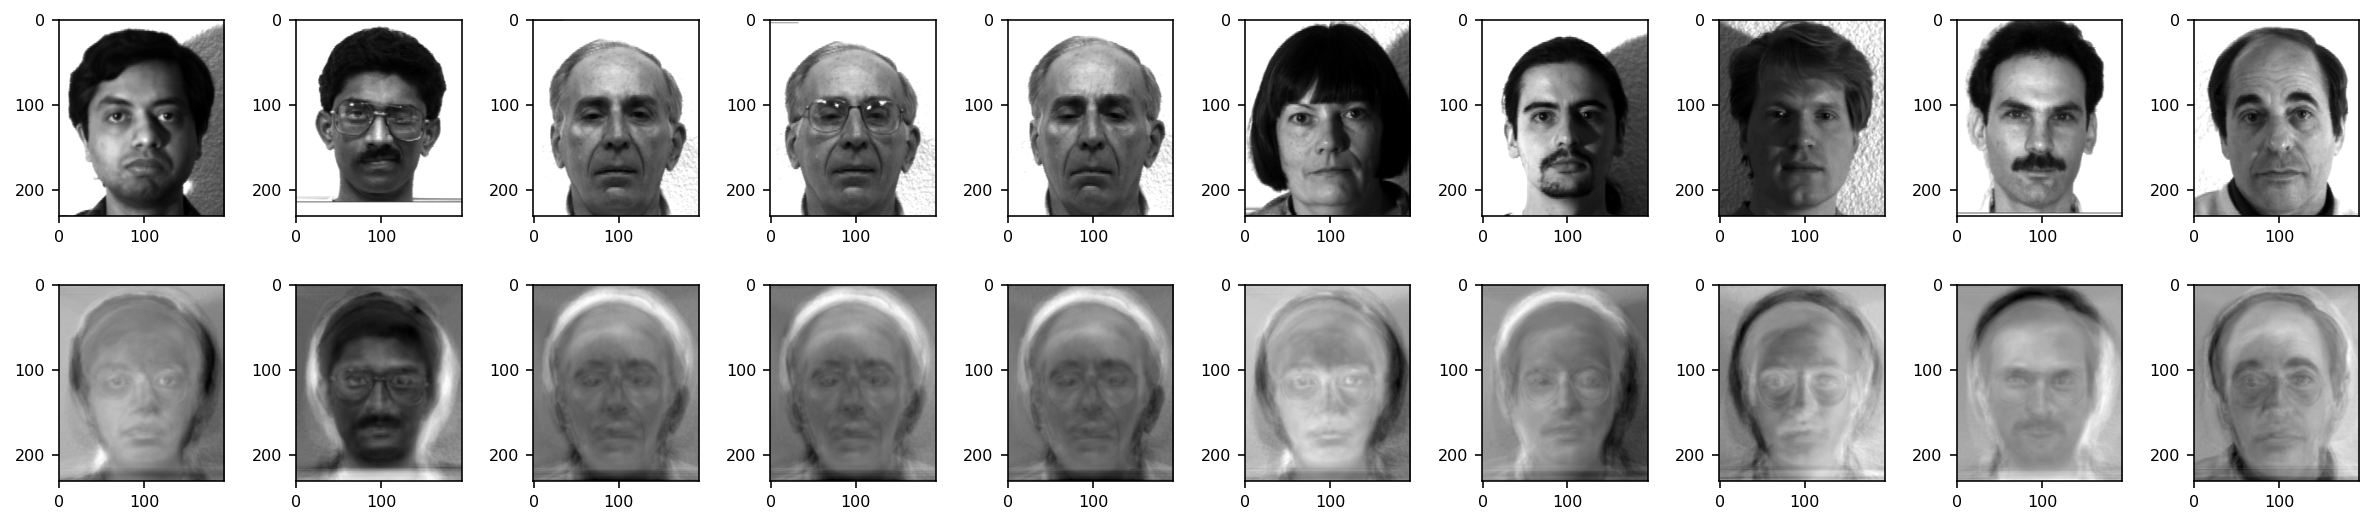

In [21]:
# reduce the dimension (projection)
Z=U.T@(X-X_mean)

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath=os.path.join('Yale_Face_Database','Testing')
X_test,y_test=read_data(filepath,H,W)
acc = accuracy(X_test,y_test,Z,y,U,X_mean,3)
print('acc: {:.2f}%'.format(acc*100))

#  linear

U shape: (45045, 50)


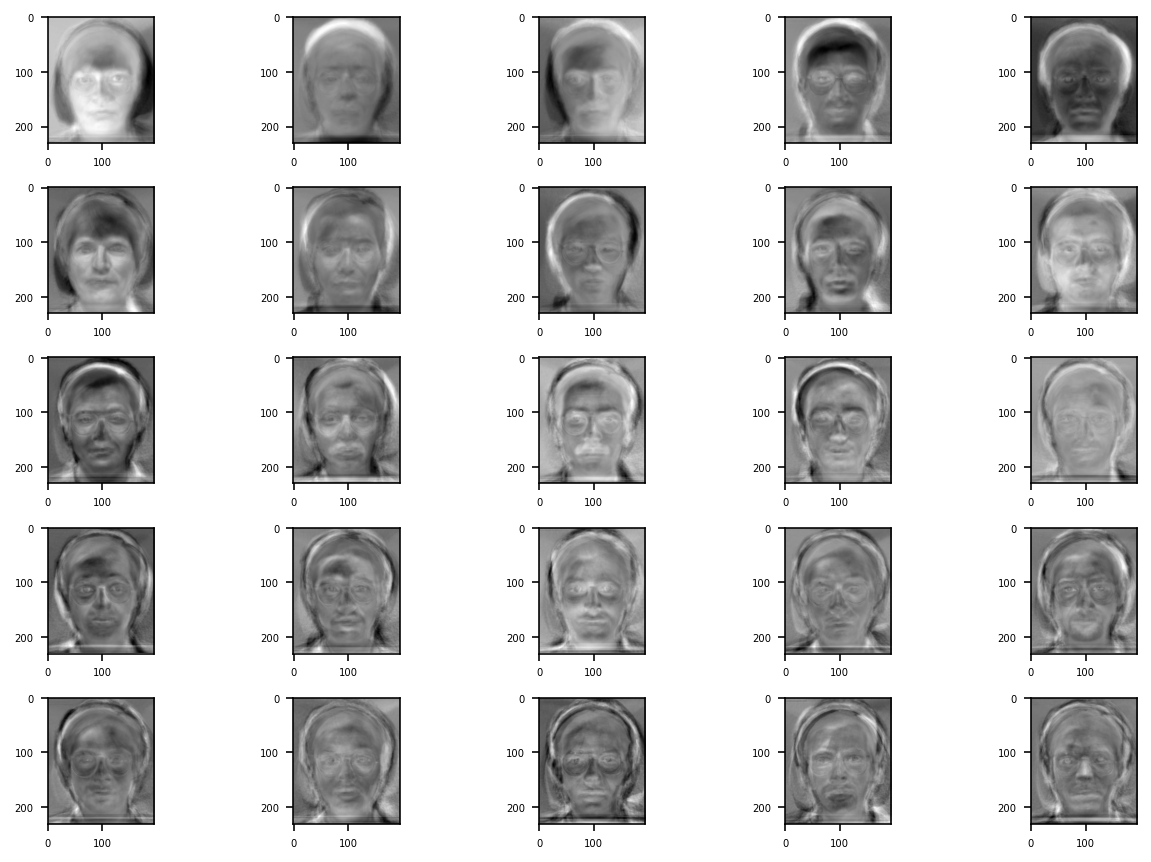

In [22]:
# Try Kernal
# The size of the picture is 231*195
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

eigenvectors=kernel_pca(X,num_dim=50, kernel = 'linear')


# Calculate transform matrix
U=eigenvectors.copy()
print('U shape: {}'.format(U.shape))

# Show the top 25 eigenface
plot_eigenface(U,25,H,W)

acc: 86.67%


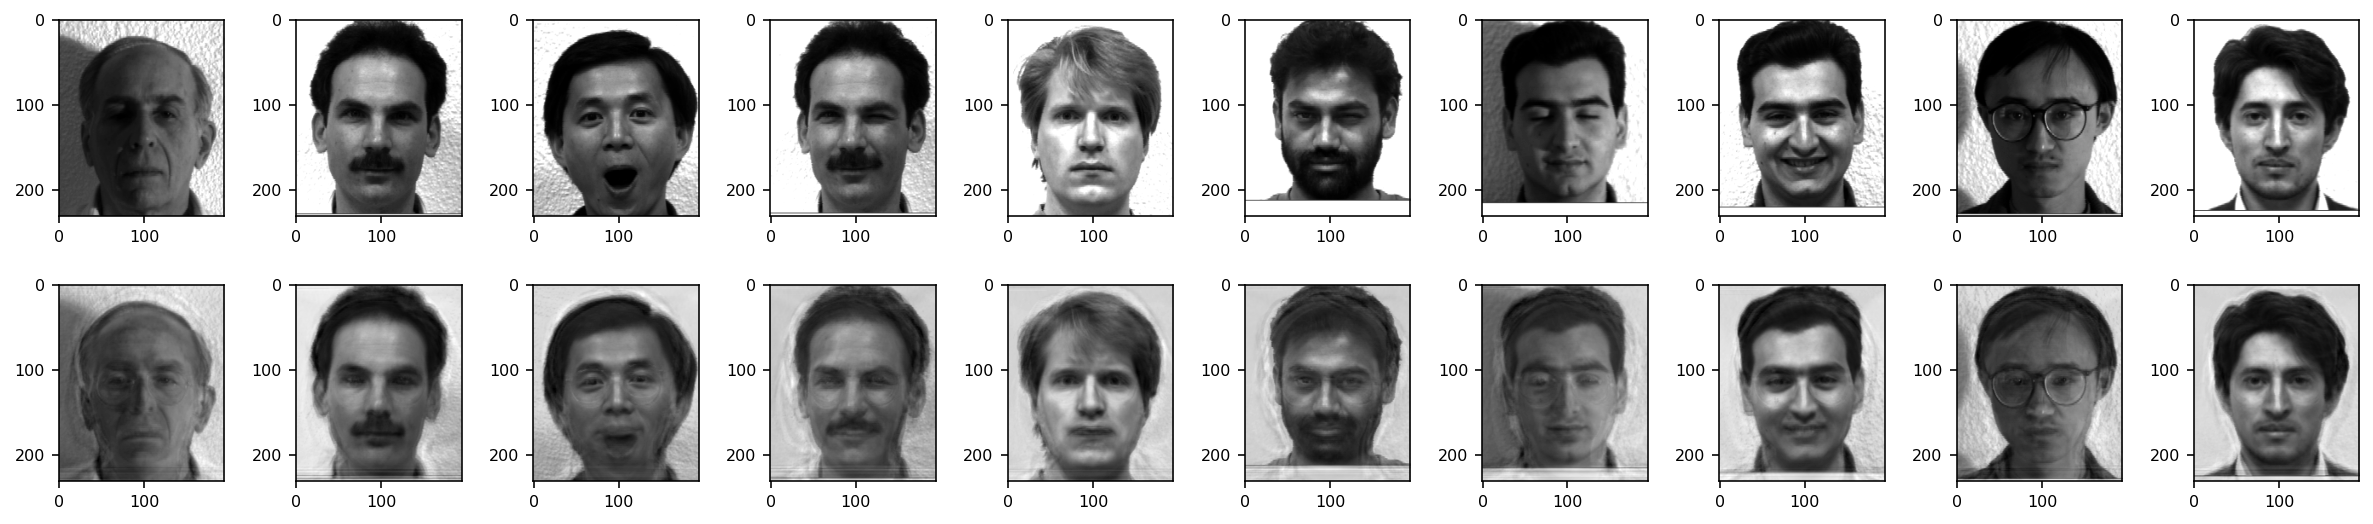

In [23]:
# reduce the dimension (projection)
Z=U.T@(X-X_mean)

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath=os.path.join('Yale_Face_Database','Testing')
X_test,y_test=read_data(filepath,H,W)
acc = accuracy(X_test,y_test,Z,y,U,X_mean,3)
print('acc: {:.2f}%'.format(acc*100))

# Fisherfaces

28
135
U shape: (45045, 27)


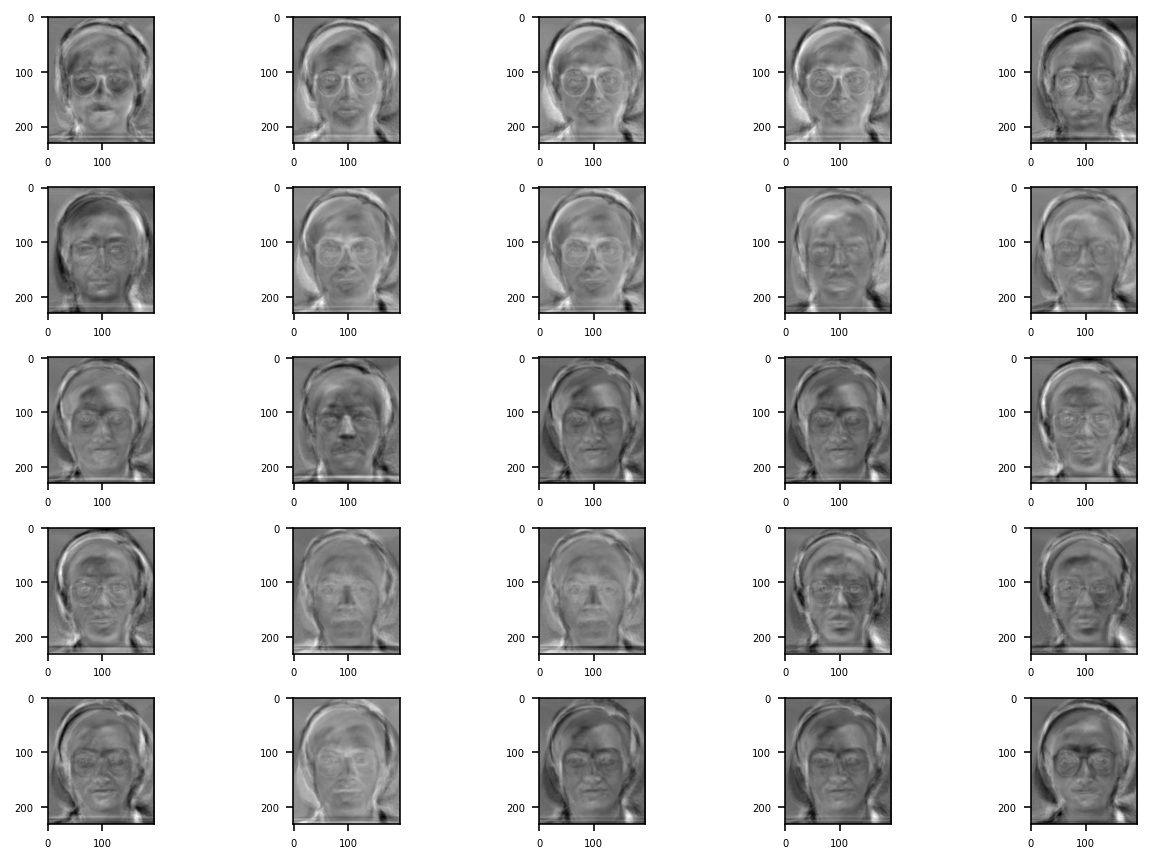

In [38]:
# LDA
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

# try
eigenvalues_pca,eigenvectors_pca,X_mean=pca(X,num_dim=28)
X_pca=eigenvectors_pca.T@(X-X_mean)
eigenvalues_lda,eigenvectors_lda=lda(X_pca,y)
'''
print(eigenvectors_pca.shape)
print(X_pca.shape)
print(eigenvectors_lda.shape)
'''
# Transform matrix
U=eigenvectors_pca@eigenvectors_lda
print('U shape: {}'.format(U.shape))

# show top 25 eigenface
plot_eigenface(U,25,H,W)


acc: 76.67%


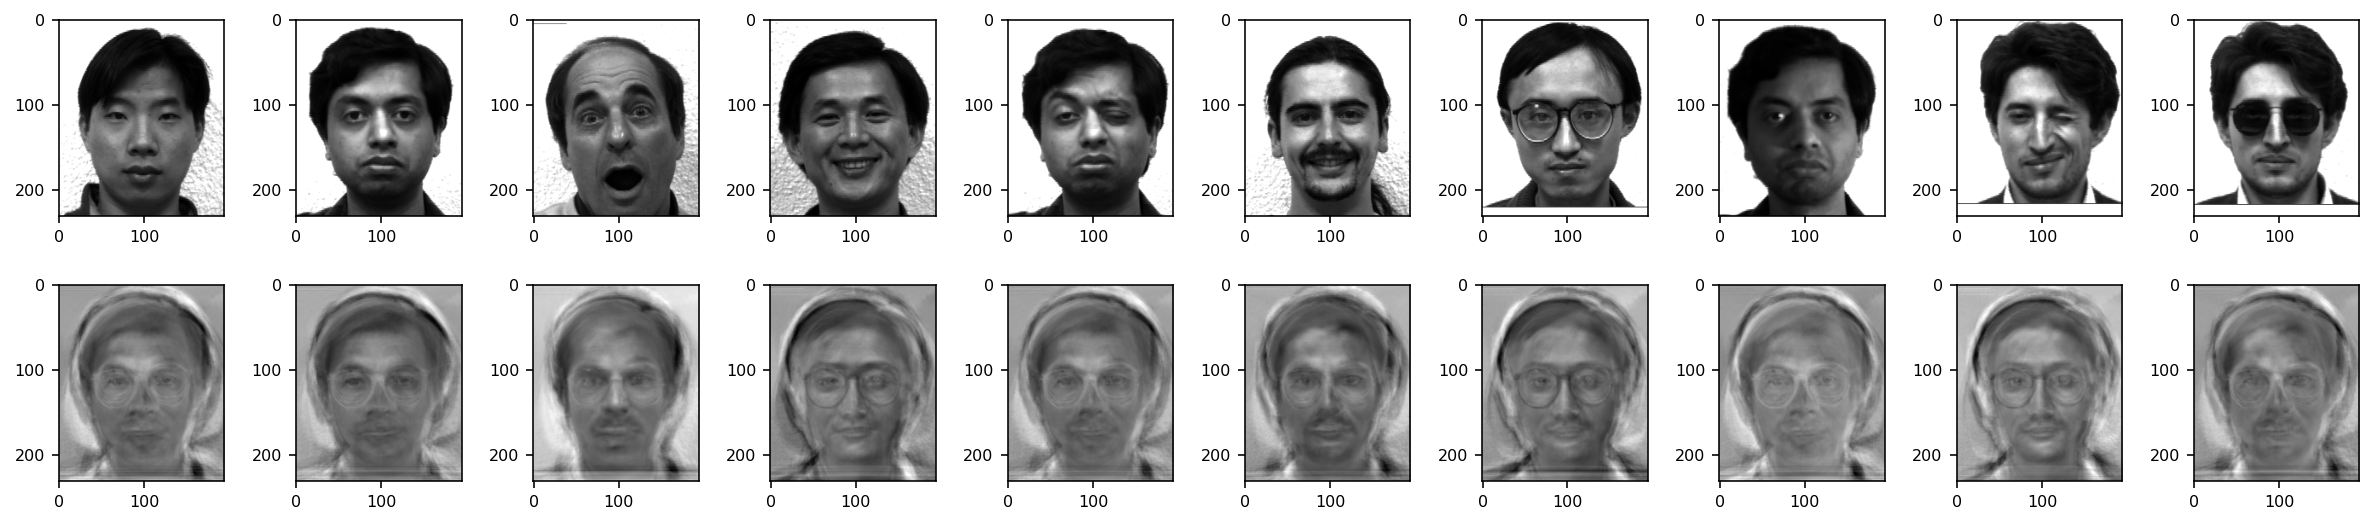

In [39]:
# reduce dim (projection)
Z=U.T@X

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath = os.path.join('Yale_Face_Database', 'Testing')
X_test, y_test = read_data(filepath, H, W)
acc =accuracy(X_test, y_test, Z, y, U, X_mean, 5)
print('acc: {:.2f}%'.format(acc * 100))

# Kernel LDA (polynomial)

135
135
U shape: (45045, 28)


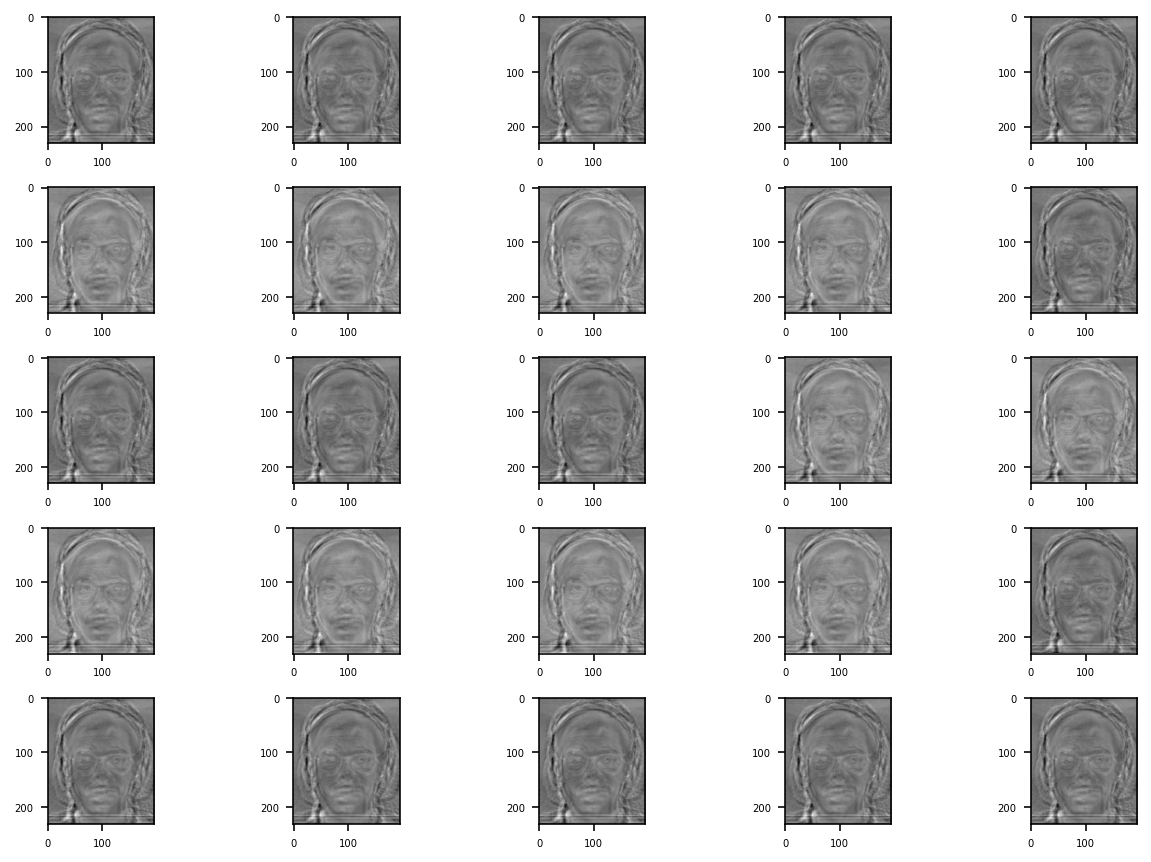

In [41]:
# LDA
H=231
W=195
filepath=os.path.join('Yale_Face_Database','Training')
X,y=read_data(filepath,H,W)

# try
eigenvalues_pca,eigenvectors_pca,X_mean=pca(X,num_dim=135)
X_pca=eigenvectors_pca.T@(X-X_mean)
eigenvalues_lda,eigenvectors_lda=kernel_lda(X_pca,y,num_dim=28,kernel ='polynomial')
'''
print(eigenvectors_pca.shape)
print(X_pca.shape)
print(eigenvectors_lda.shape)
'''
# Transform matrix
U=eigenvectors_pca@eigenvectors_lda
print('U shape: {}'.format(U.shape))

# show top 25 eigenface
plot_eigenface(U,25,H,W)

acc: 6.67%


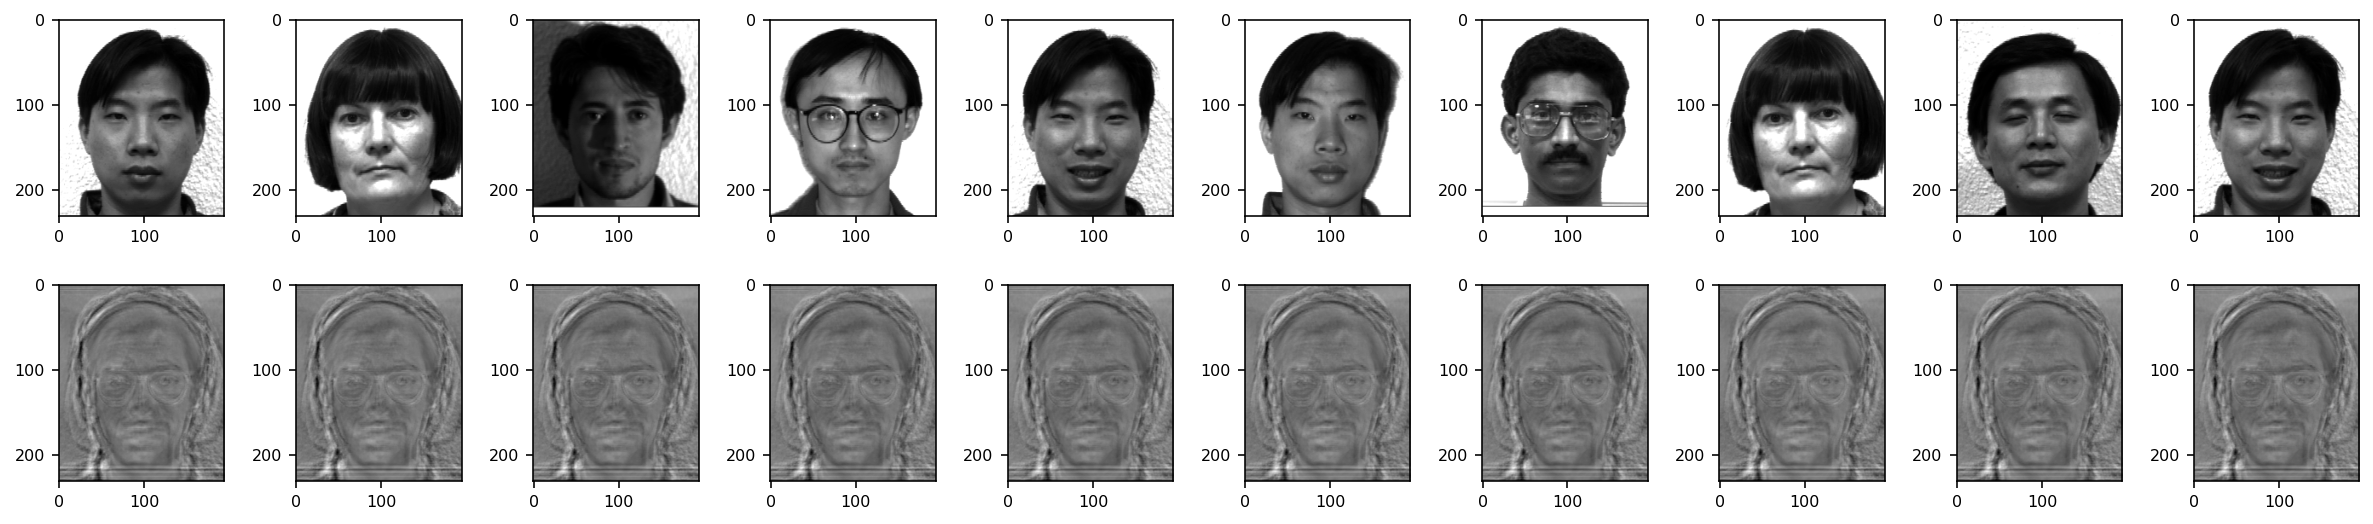

In [42]:
# reduce dim (projection)
Z=U.T@X

# recover
X_recover=U@Z+X_mean
show_reconstruction(X,X_recover,10,H,W)

# accuracy
filepath = os.path.join('Yale_Face_Database', 'Testing')
X_test, y_test = read_data(filepath, H, W)
acc =accuracy(X_test, y_test, Z, y, U, X_mean, 5)
print('acc: {:.2f}%'.format(acc * 100))